# Think Bayes

Second Edition

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from empiricaldist import Pmf

## The Decision-Making Box

One day Alice tells her friend, Bob, "I bought a random decision-making box.  Every time you press this button, it says 'yes' or 'no'.  I've tried it a few times, and I think it says 'yes' 90% of the time."

Bob says he has some important decisions to make and asks if he can borrow the box.  The next day, he returns the box to Alice and says, "I used the box several times, and I also think it says 'yes' 90% of the time."

Alice says, "It sounds like we agree, but just to make sure, we should compare our predictions.  Suppose I press the button twice; what do you think is the probability it says 'yes' both times?"

Bob does some calculations and reports the predictive probability 81.56%.

Alice says, "That's interesting.  I got a slightly different result, 81.79%.  So maybe we don't agree after all."

Bob says, "Well let's see what happens if we combine our data.  I can tell you how many times I pressed the button and how many times it said 'yes'."

Alice says, "That's ok, I don't actually need your data; it's enough if you tell me what prior distribution you used."

Bob tells her he used a Jeffreys prior.

Alice does some calculations and says, "Ok, I've updated my beliefs to take into account your data as well as mine.  Now I think the probability of 'yes' is 91.67%."

Bob says, "That's interesting.  Based on your data, you thought the probability was 90%, and based on my data, I thought it was 90%, but when we combine the data, we get a different result.  Tell me what data you saw, and let me see what I get."

Alice tells him she pressed the button 8 times and it always said 'yes'.

"So," says Bob, "I guess you used a uniform prior."

Bob does some calculations and reports, "Taking into account all of the data, I think the probability of 'yes' is 93.45%."

Alice says, "So when we started, we had seen different data, but we came to the same conclusion."

"Sort of," says Bob, "we had the same posterior mean, but our posterior distributions were different; that's why we made different predictions for pressing the button twice." 

Alice says, "And now we're using the same data, but we have different posterior means.  Which makes sense, because we started with different priors."

"That's true," says Bob, "but if we collect enough data, eventually our posterior distributions will converge, at least approximately."

"Well that's good," says Alice.  "Anyway, how did those decisions work out yesterday?"

"Mostly bad," says Bob.  "It turns out that saying 'yes' 93% of the time is a terrible way to make decisions."

## Explanation

Suppose Alice starts with a uniform prior, with is a beta distribution with parameters (1, 1).  She presses the button 8 times and it says 'yes' every time.  Her posterior distribution is a beta distribution with parameters (9, 1); the posterior mean is 90%.

For this example I'm using distributions we can compute analytically, but the entire conversation works for arbitrary distributions.

In [3]:
from scipy.stats import beta

yes = 8
no = 0
posterior_beta_alice = beta(yes+1, no+1)
posterior_beta_alice.mean()

0.9

Bob never said so, but he pressed the button 13 times and got 'yes' 12 times.  He used a Jeffreys prior, with is a beta distribution with parameters (1/2, 1/2), so his posterior is a beta distribution with parameters (13.5, 1.5), and his posterior mean is 90%.

In [4]:
yes = 13
no = 1
posterior_beta_bob = beta(yes+1/2, no+1/2)
posterior_beta_bob.mean()

0.9

Now, if we press the button twice, what's the chance of getting 'yes' both times?  We could compute it analytically, but it will be convenient to approximate these distributions with a discrete PMF.

The following function takes a `beta` object that represents a beta distribution and returns a `Pmf` object that represents a discrete approximation.

In [5]:
def make_beta(dist, **options):
    """PMF to approximate a beta distribution.
    
    dist: `beta` object
    
    returns: Pmf
    """
    qs = np.linspace(0.4, 1, 1000, endpoint=False)
    ps = dist.pdf(qs)
    pmf = Pmf(ps, qs)
    pmf.normalize()
    return pmf

`qs` is the range of possible probabilities, from 0.4 to (almost) 1.0.  I omitted the end point, 1.0, because the Jeffreys prior goes to infinity at 0 and 1.

Here's what the posterior distributions look like for Alice and Bob.

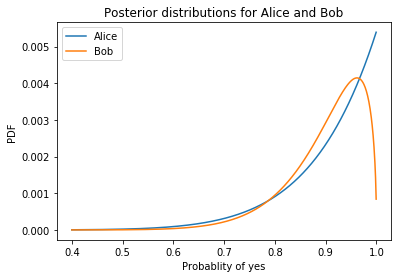

In [6]:
posterior_pmf_alice = make_beta(posterior_beta_alice)
posterior_pmf_alice.plot(label='Alice')

posterior_pmf_bob = make_beta(posterior_beta_bob)
posterior_pmf_bob.plot(label='Bob')

plt.xlabel('Probablity of yes')
plt.ylabel('PDF')
plt.title("Posterior distributions for Alice and Bob")
plt.legend();

Even though they have the same posterior mean, they are substantially different, especially for probabilities greater than 90%.

Just to check, here are the posterior means for the discrete PMFs.

In [7]:
mean_alice = posterior_pmf_alice.mean()
mean_alice

0.8998707783503778

In [8]:
mean_bob = posterior_pmf_bob.mean()
mean_bob

0.8999899487704509

They are close to 90%.

Now, when Bob offers to share his data, Alice says it's not necessary as long as she knows what prior he used.

Since he used a beta prior, she knows his posterior is also a beta distribution.  She knows the mean is 90%; she also knows that the predictive probability for getting 'yes' twice is 81.56%.  And that's enough to figure out Bob's posterior distribution.

The key is to realize that the predictive probability is the second moment of the posterior distribution:

$ \sum p_i q_i^2 $

where each $q_i$ is a quantity in the posterior distribution (possible probabilities of 'yes') and each $p_i$ is the corresponding probability.

This summation is the expectation of $q^2$, written $E[q^2]$, which is related to the variance of the posterior distribution:

$ \mathrm{var}(q) = E[q^2] - E[q]^2 $

where $E[q]$ is the mean of the posterior distribution.

To show that's true, here's Bob's predictive probability:

In [9]:
pred_bob = np.sum(posterior_pmf_bob.ps * posterior_pmf_bob.qs**2)
pred_bob

0.8156022529251691

Here's the variance Alice computes:

In [10]:
pred_bob - mean_bob**2

0.005620345037330221

And here's the actual variance of Bob's posterior distribution.

In [11]:
posterior_pmf_bob.var()

0.005620345037330041

Pretty close.

Now, knowing the mean and variance, Alice can do some algebra to figure out the parameters of Bob's distribution.  So let's assume she knows `posterior_pmf_bob`.

Bob told her he used a Jeffrey's prior, so Alice can make a `Pmf` to approximate it.

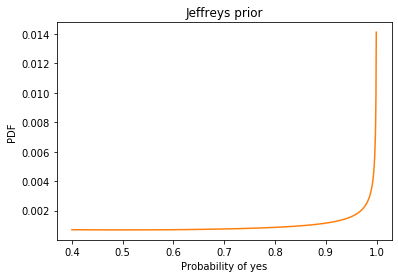

In [12]:
prior_beta_bob = beta(0.5, 0.5)
prior_pmf_bob = make_beta(prior_beta_bob)
prior_pmf_bob.plot(color='C1')
plt.xlabel('Probability of yes')
plt.ylabel('PDF')
plt.title('Jeffreys prior');

At this point, Alice knows Bob's prior and posterior distributions, so she can use Bayes's Theorem to compute the likelihood of the data.

In [13]:
likelihood_bob = posterior_pmf_bob / prior_pmf_bob

Alice still hasn't seen Bob's data, but she doesn't have to; now that she knows the likelihood of Bob's data, she can use it to do a Bayesian update in the usual way:

In [14]:
posterior2_pmf_alice = posterior_pmf_alice * likelihood_bob
posterior2_pmf_alice.normalize()

1.7823064349467608

The result is a posterior that combines Alice's prior with data from both Alice and Bob.  And here's the posterior mean.

In [15]:
posterior2_pmf_alice.mean()

0.9166654148151903

To check it, we can compute her posterior mean if she had used all of the data.

In [16]:
yes = 21
no = 1
posterior2_beta_alice = beta(yes+1, no+1)
posterior2_beta_alice.mean()

0.9166666666666666

Pretty close.

Now, Alice tells Bob she pressed the button 8 times and got 'yes' every time.

That's enough for Bob to figure out what prior she used.  He knows the mean and second moment of her posterior distribution, which is enough to approximate it with a beta distribution.

And since he knows what data she saw, he can figure out the likelihood she applied.  Here it is:

In [17]:
from scipy.stats import binom

ps = posterior_pmf_alice.qs
likelihood_alice = binom.pmf(8, 8, ps)

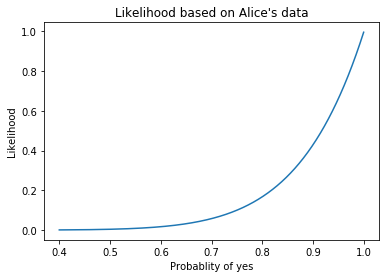

In [18]:
plt.plot(ps, likelihood_alice)
plt.xlabel('Probablity of yes')
plt.ylabel('Likelihood')
plt.title("Likelihood based on Alice's data");

Now Bob can compute Alice's prior distribution.

In [19]:
implied_prior = posterior_pmf_alice / likelihood_alice
implied_prior.normalize()

5.416021773464143

And it sure looks uniform.

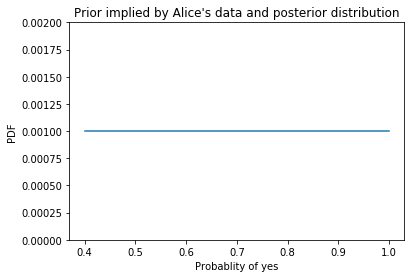

In [20]:
implied_prior.plot()
plt.ylim([0, 0.002])

plt.xlabel('Probablity of yes')
plt.ylabel('PDF')
plt.title("Prior implied by Alice's data and posterior distribution");

Finally, Bob can update his posterior distribution with the likelihood of Alice's data.

In [21]:
posterior2_pmf_bob = posterior_pmf_bob * likelihood_alice
posterior2_pmf_bob.normalize()
posterior2_pmf_bob.mean()

0.9347598645600801

The result takes into account Bob's prior, Bob's data, and Alice's data, which we can confirm by computing the posterior distribution with a Jeffreys prior and all of the data.

In [22]:
yes = 21
no = 1
posterior2_beta_bob = beta(yes+1/2, no+1/2)
posterior2_beta_bob.mean()

0.9347826086956522

Pretty close.

## Summary

* If two people have different priors OR they see different data, they will generally have different posterior distributions.

* If two posterior distributions have the same mean, some of their predictions will be the same, but many others will not.

* If you are given summary statistics from a posterior distribution, you might be able to figure out the rest of the distribution, depending on what other information you have. For example, if you know the posterior is a two-parameter beta distribution (or is well-modeled by one) you can recover it from the mean and second moment, or the mean and a credible interval, or almost any other pair of statistics.

* If someone has done a Bayesian update using data you don't have access to, you might be able to "back out" their likelihood function by dividing their posterior distribution by the prior.

* If you are given a posterior distribution and the data used to compute it, you can back out the prior by dividing the posterior by the likelihood of the data (unless the prior contains values with zero likelihood).

* If you are given summary statistics from two posterior distributions, you might be able to combine them.  In general, you need enough information to recover both posterior distributions and at least one prior.